In [54]:
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
import skimage.transform
import PIL
import imageio
from IPython.display import clear_output

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [55]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2] > 3:
            assert(img[:,:,3] != 255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path / (item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

In [56]:
class Dataset():
    def __init__(self, data, source_transform, target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128), interpolation=PIL.Image.NEAREST),
    tsf.ToTensor()]
)
dataset = Dataset(train_data, s_trans, t_trans)

In [57]:
X_train = [dataset[i] for i in range (0, 20)]

In [59]:
class RotatedDataset():
    def __init__(self, data, angle):
        self.datas = data
        self.angle = angle
        self.s_transform = tsf.Compose([
            tsf.ToPILImage(),
            tsf.Lambda(lambda x: tsf.functional.affine(x, self.angle,
                                                       translate=(0, 0), scale=1, 
                                                       shear = False)),
            tsf.Resize((128, 128)),
            tsf.ToTensor(),
            tsf.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
        ])
        self.t_transform = t_trans = tsf.Compose([
            tsf.ToPILImage(),
            tsf.Lambda(lambda x: tsf.functional.affine(x, self.angle,
                                                       translate=(0, 0), scale=1,
                                                       shear = False)),
            tsf.Resize((128, 128), interpolation=PIL.Image.NEAREST),
            tsf.ToTensor()
        ])
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)

In [60]:
for angle in range(90, 360, 90):
    rotated_dataset = RotatedDataset(train_data, angle)
    for i in range(0, 20):
        X_train.append(rotated_dataset[i])

In [61]:
len(X_train)

80

In [62]:
dtype=t.FloatTensor

def _epoch(network, loss, loader, optimizer):
    losses = []
    for X, y in loader:
        X = X.type(dtype)
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    return losses

def train(network, train_loader, epochs, learning_rate, loss):
    optimizer = t.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    network = network.train()
    for epoch in range(epochs):
        losses = _epoch(network, loss, train_loader, optimizer)
        train_loss_epochs.append(np.mean(losses))
        clear_output(True)
        print('Epoch {0}... Loss: {1:.3f}'.format(
                    epoch, train_loss_epochs[-1]))
        plt.figure(figsize=(12, 5))
        plt.plot(train_loss_epochs)
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.grid()
        plt.show()
    return train_loss_epochs

In [68]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cbr_unit = nn.Sequential(
                conv_mod, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
            )
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs

class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs

In [64]:
class segnet(nn.Module):
    def __init__(self, n_classes=21, in_channels=3, is_unpooling=True):
        super(segnet, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling

        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)

        up5 = self.up5(down5, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)

        return up1

    def init_vgg16_params(self, vgg16):
        blocks = [self.down1, self.down2, self.down3, self.down4, self.down5]

        features = list(vgg16.features.children())

        vgg_layers = []
        for _layer in features:
            if isinstance(_layer, nn.Conv2d):
                vgg_layers.append(_layer)

        merged_layers = []
        for idx, conv_block in enumerate(blocks):
            if idx < 2:
                units = [conv_block.conv1.cbr_unit, conv_block.conv2.cbr_unit]
            else:
                units = [
                    conv_block.conv1.cbr_unit,
                    conv_block.conv2.cbr_unit,
                    conv_block.conv3.cbr_unit,
                ]
            for _unit in units:
                for _layer in _unit:
                    if isinstance(_layer, nn.Conv2d):
                        merged_layers.append(_layer)

        assert len(vgg_layers) == len(merged_layers)

        for l1, l2 in zip(vgg_layers, merged_layers):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data

In [65]:
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1) + 1) / (m1.sum(1) + m2.sum(1) + 1)
        score = 1 - score.sum()/num
        return score

In [66]:
train_loader = t.utils.data.DataLoader(X_train, batch_size=4, shuffle=True)

Epoch 9... Loss: 0.128


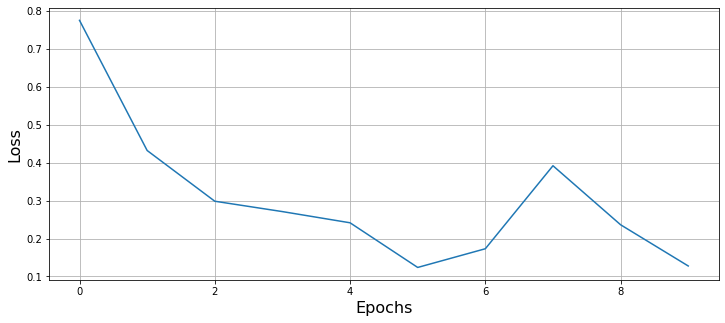

[0.7754009395837784,
 0.432223042845726,
 0.2984766215085983,
 0.2711265593767166,
 0.2416189968585968,
 0.12386472523212433,
 0.17316720485687256,
 0.39203941822052,
 0.23640018999576567,
 0.12774451971054077]

In [69]:
model = segnet(1, 3)
train(model, train_loader, 10, 0.01, soft_dice_loss)

In [70]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [71]:
os.makedirs("segnet_result")

In [72]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("segnet_result/%s.png" % (ex_id + 1), tm)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [

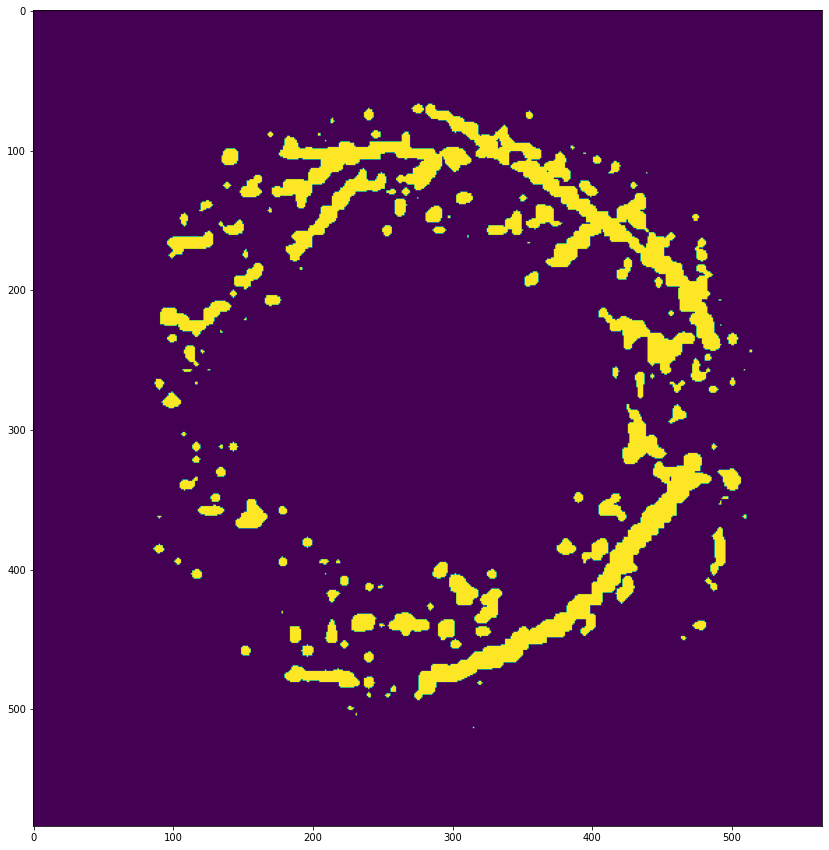

In [73]:
plt.figure(figsize=(15, 15))
plt.imshow(tm)